# 1. Temporal Analysis (Seasonality & Logistics)

✅ Project root added to path: c:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence
✅ Feature engineering module loaded successfully.
⏳ Loading processed data...
📊 Generating Operational Intensity Heatmap...


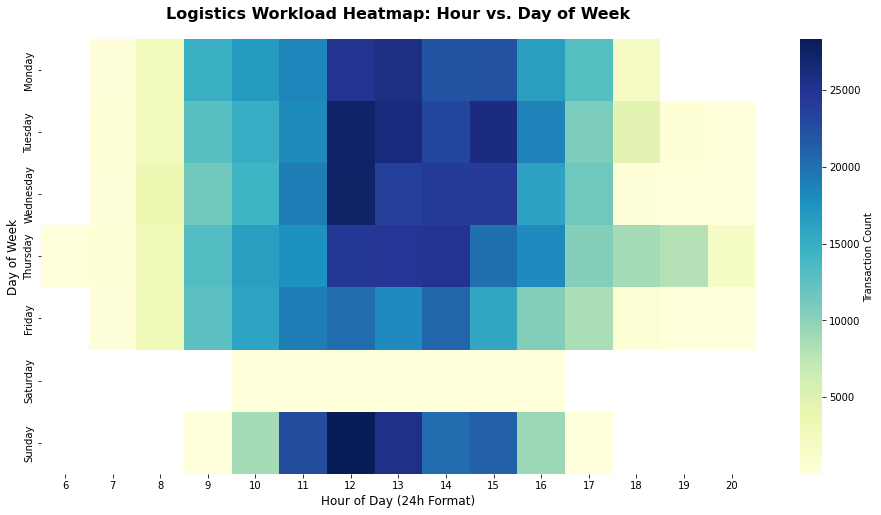

✅ Temporal analysis visualizations complete.


In [1]:
# === SECTION 1: TEMPORAL ANALYSIS (SEASONALITY & LOGISTICS) ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

# 1.1 Project Path Setup
# Adding the parent directory to sys.path to enable 'src' imports
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Project root added to path: {PROJECT_ROOT}")

# 1.2 Import Custom Logic
try:
    from src.feature_engineering import add_time_features
    print("✅ Feature engineering module loaded successfully.")
except ModuleNotFoundError:
    print("❌ Error: Could not find 'src' folder. Ensure your folder structure is correct.")

# 1.3 Configuration & Data Loading
PROCESSED_PATH = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
SC_PALETTE = ["#1B4F72", "#2E86C1", "#5DADE2", "#A9CCE3"]

print("⏳ Loading processed data...")
df = pd.read_csv(PROCESSED_PATH, parse_dates=['InvoiceDate'])

# 1.4 Apply Feature Engineering
df = add_time_features(df)

# 1.5 Logistics Heatmap Analysis
print("📊 Generating Operational Intensity Heatmap...")

# Days order for logical sorting
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Creating pivot table for the heatmap
pivot_heatmap = df.pivot_table(
    index='DayName', 
    columns='Hour', 
    values='Invoice', 
    aggfunc='count'
).reindex(DAYS_ORDER)

# Visualization
plt.figure(figsize=(16, 8))
sns.heatmap(
    pivot_heatmap, 
    annot=False, 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Transaction Count'}
)

plt.title('Logistics Workload Heatmap: Hour vs. Day of Week', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of Day (24h Format)', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

print("✅ Temporal analysis visualizations complete.")

# 2. Customer Intelligence (RFM Segmentation)

⏳ 'TotalSum' not found. Calculating Revenue (Quantity * Price)...
✅ RFM Metrics calculated successfully.


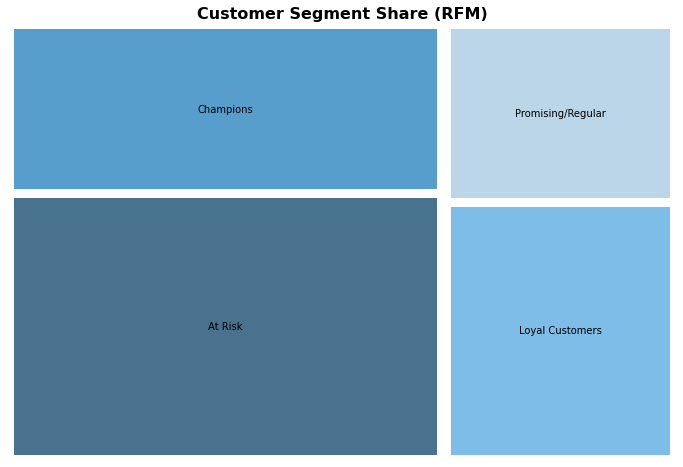

✅ Customer segmentation visualized.


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Segment
Customer ID,,,,,,,
12346.0,529,11,372.86,1,5,2,At Risk
12347.0,2,8,5377.72,5,4,5,Champions
12348.0,75,5,1057.24,3,4,3,Loyal Customers
12349.0,19,3,3498.94,5,3,5,Loyal Customers
12350.0,310,1,294.40,2,1,2,At Risk


In [2]:
# === SECTION 2: CUSTOMER INTELLIGENCE (RFM SEGMENTATION) ===
from src.feature_engineering import calculate_rfm_metrics
import squarify # Install if needed: pip install squarify

# 2.1 Calculate Base Metrics
rfm = calculate_rfm_metrics(df)

# 2.2 Scoring using Quantiles (1 to 5)
# R_Score: Lower recency is better (5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
# F & M Scores: Higher values are better (5)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# 2.3 Segment Labeling Logic
def assign_segment(row):
    r, f = int(row['R_Score']), int(row['F_Score'])
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r <= 2:
        return 'At Risk'
    else:
        return 'Promising/Regular'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# 2.4 Visualization: Market Share Treemap
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

plt.figure(figsize=(12, 8))
squarify.plot(sizes=segment_counts['Count'], label=segment_counts['Segment'], 
              alpha=0.8, color=SC_PALETTE, pad=True)

plt.title('Customer Segment Share (RFM)', fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

print("✅ Customer segmentation visualized.")
display(rfm.head())

# 3. Inventory Intelligence (ABC Analysis)

⏳ Performing Pareto (ABC) Analysis on inventory...
✅ ABC Analysis calculation complete.


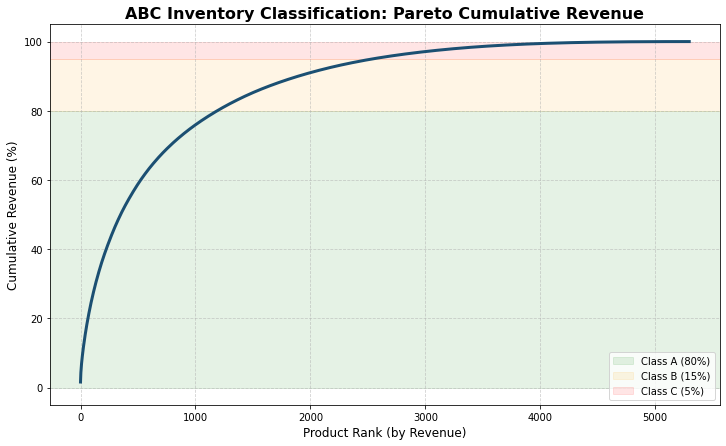

📊 --- ABC Classification Summary ---


,SKU_Count,Revenue_Contribution
ABC_Class,,
A,1190,12838615.61
B,1353,2408541.19
C,2755,802879.16


In [3]:
# === SECTION 3: INVENTORY INTELLIGENCE (ABC ANALYSIS) ===
from src.feature_engineering import perform_abc_analysis

# 3.1 Execute ABC Classification
print("⏳ Performing Pareto (ABC) Analysis on inventory...")
df_abc = perform_abc_analysis(df)

# 3.2 Visualizing the Results
plt.figure(figsize=(12, 7))

# Plotting the Cumulative Distribution (Lorenz Curve style)
sns.lineplot(data=df_abc, x=df_abc.index, y='Revenue_Share_Pct', color='#1B4F72', linewidth=3)

# Add shading for ABC Zones
plt.axhspan(0, 80, alpha=0.1, color='green', label='Class A (80%)')
plt.axhspan(80, 95, alpha=0.1, color='orange', label='Class B (15%)')
plt.axhspan(95, 100, alpha=0.1, color='red', label='Class C (5%)')

plt.title('ABC Inventory Classification: Pareto Cumulative Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Product Rank (by Revenue)', fontsize=12)
plt.ylabel('Cumulative Revenue (%)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 3.3 Summary Metrics
summary = df_abc.groupby('ABC_Class').agg({
    'Description': 'count',
    'TotalSum': 'sum'
}).rename(columns={'Description': 'SKU_Count', 'TotalSum': 'Revenue_Contribution'})

print("📊 --- ABC Classification Summary ---")
display(summary)

# 4. Behavioral Correlations (Root Cause Analysis)

⏳ Cancellation dataset not found in memory. Loading from CSV...
✅ Cancellations Loaded: 19,494 records.
⏳ Executing Service Failure Impact Analysis...
✅ Cancellation correlation data merged without categorical conflicts.


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_21164\1972360934.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


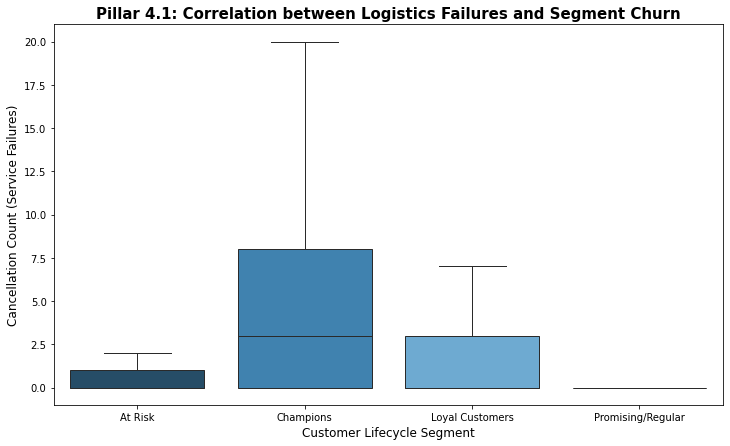

⏳ Calculating Price Elasticity for Top SKUs...
✅ Price elasticity metrics calculated.


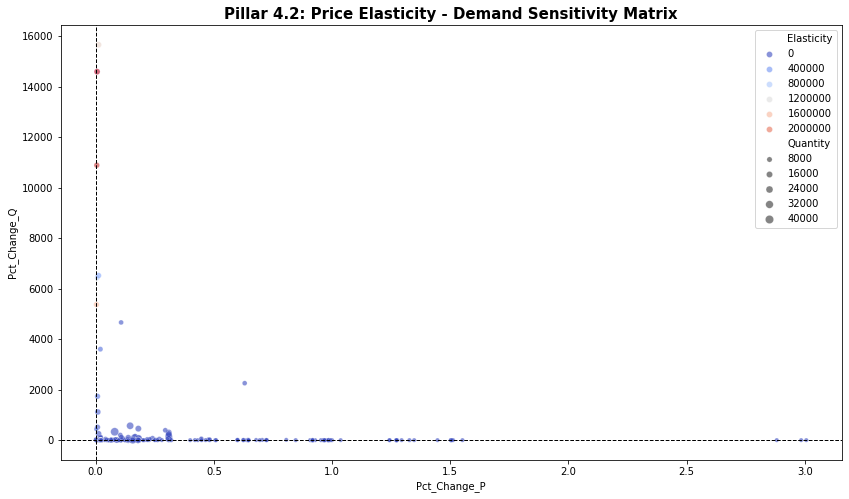

✅ Root Cause Analysis complete. Insights ready for portfolio summary.


In [5]:
# === IMPORTS ===
from src.feature_engineering import analyze_cancellation_correlation, calculate_price_elasticity

# === PATHS & CONSTANTS ===
CANCELLATIONS_CSV = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cancellation_retail_data.csv"

# 4.1 Data Verification & Loading
if 'df_canc' not in locals():
    print("⏳ Cancellation dataset not found in memory. Loading from CSV...")
    df_canc = pd.read_csv(CANCELLATIONS_CSV, parse_dates=['InvoiceDate'])
    # Ensure ID alignment
    df_canc['Customer ID'] = df_canc['Customer ID'].astype(float) 
    print(f"✅ Cancellations Loaded: {len(df_canc):,} records.")

# 4.2 Churn vs. Cancellations Analysis
print("⏳ Executing Service Failure Impact Analysis...")
# Ensure 'rfm' from Section 2 is present
try:
    df_corr = analyze_cancellation_correlation(rfm, df_canc)
    
    plt.figure(figsize=(12, 7))
    sns.boxplot(
        data=df_corr, 
        x='Segment', 
        y='CancellationCount', 
        palette=SC_PALETTE,
        showfliers=False # Removes extreme outliers for a cleaner business view
    )

    plt.title('Pillar 4.1: Correlation between Logistics Failures and Segment Churn', fontsize=15, fontweight='bold')
    plt.xlabel('Customer Lifecycle Segment', fontsize=12)
    plt.ylabel('Cancellation Count (Service Failures)', fontsize=12)
    plt.show()
    
except NameError:
    print("❌ Error: 'rfm' dataframe not found. Please run Section 2 first.")

# 4.3 Price Elasticity of Demand
print("⏳ Calculating Price Elasticity for Top SKUs...")
df_elasticity = calculate_price_elasticity(df)

# Filter for High-Volume items to ensure statistical significance
top_skus = df.groupby('Description')['Quantity'].sum().nlargest(50).index
df_el_filtered = df_elasticity[df_elasticity['Description'].isin(top_skus)]

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_el_filtered, 
    x='Pct_Change_P', 
    y='Pct_Change_Q', 
    size='Quantity', 
    hue='Elasticity', 
    palette='coolwarm', 
    alpha=0.6
)

plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.title('Pillar 4.2: Price Elasticity - Demand Sensitivity Matrix', fontsize=15, fontweight='bold')
plt.show()

print(f"✅ Root Cause Analysis complete. Insights ready for portfolio summary.")